# ECG Prediction using PPG signals

In [1]:
import os
import sys
import psutil
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import euclidean
import random

# Add the parent directory (i.e. transformer, means parent directory of 'scripts' and 'notebooks') to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import the function
from scripts.m1_functions import *
from scripts.m1_classes import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
device = select_device()

Using cpu device


In [3]:
mask = torch.triu(torch.ones(5, 5), diagonal=1)
mask.masked_fill(mask == 1, float('-inf'))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [4]:
df_filtered = data_loader_filtered()
df_original = data_loader_original()
df_filtered_single = data_loader_filtered_single(subject=1, action='run')
df_original_single = data_loader_original_single(subject=1, action='run')

In [5]:
df_filtered

ecg    red ppg     ir ppg  green ppg action  subject
0           174.974839  15.310121  36.949744   2.448764    run        1
1           331.238034  15.882665  38.815851   2.059867    run        1
2           491.147661  16.451893  40.676736   1.668106    run        1
3           654.727822  17.013543  42.526748   1.276741    run        1
4           821.942114  17.563388  44.360139   0.888882    run        1
...                ...        ...        ...        ...    ...      ...
16217127  12152.507664 -13.113156 -19.155829  -4.764775   walk       22
16217128  11294.708985 -11.987261 -17.420184  -4.331053   walk       22
16217129  10419.925784 -10.886987 -15.741791  -3.911351   walk       22
16217130   9538.677108  -9.819849 -14.129908  -3.508117   walk       22
16217131   8661.229189  -8.792804 -12.592858  -3.123554   walk       22

[16217132 rows x 6 columns]

In [6]:
df_original

ecg  red ppg  ir ppg  green ppg action  subject
0         31978    85787   99285       7017    run        1
1         32078    85794   99281       7022    run        1
2         32148    85782   99269       7015    run        1
3         32257    85782   99269       7015    run        1
4         32380    85787   99281       7015    run        1
...         ...      ...     ...        ...    ...      ...
16217127  30237    74877   83310       5115   walk       22
16217128  28733    74882   83318       5119   walk       22
16217129  27303    74879   83316       5118   walk       22
16217130  26209    74882   83333       5122   walk       22
16217131  25556    74884   83333       5124   walk       22

[16217132 rows x 6 columns]

In [7]:
df_filtered_single

ecg    red ppg     ir ppg  green ppg
0        174.824589  15.241058  37.010241   2.459990
1        331.110490  15.813674  38.876235   2.071091
2        491.042848  16.382975  40.737007   1.679327
3        654.645766  16.944698  42.586905   1.287959
4        821.882845  17.494616  44.420182   0.900096
...             ...        ...        ...        ...
245269  4551.136656   5.777738  11.154960   0.456748
245270  4158.062007   5.064347   9.937873   0.427576
245271  3773.825229   4.412057   8.805548   0.396795
245272  3401.220301   3.819186   7.757095   0.365016
245273  3042.801939   3.283643   6.791162   0.332808

[245274 rows x 4 columns]

In [8]:
df_original_single

ecg  red ppg  ir ppg  green ppg
0       31978    85787   99285       7017
1       32078    85794   99281       7022
2       32148    85782   99269       7015
3       32257    85782   99269       7015
4       32380    85787   99281       7015
...       ...      ...     ...        ...
245269  29041    87321  100587       7381
245270  28402    87321  100583       7372
245271  27813    87348  100578       7374
245272  27299    87326  100595       7378
245273  26952    87319  100581       7378

[245274 rows x 4 columns]

In [9]:
def normalization_group_action(df):
    # Initialize a dictionary to store scalers for each subject-action group
    scalers = {}

    # Placeholder for normalized data
    normalized_data = []

    # Group data by subject and action
    grouped_data = df.groupby(['subject', 'action'])
    print(grouped_data.first())
    
    for (subject, action), group in grouped_data:
        # Initialize scalers for PPG (inputs) and ECG (targets)
        scaler_input = MinMaxScaler(feature_range=(-1, 1))  # For PPG signals
        scaler_target = MinMaxScaler(feature_range=(-1, 1))  # For ECG signals

        # Fit and transform the PPG columns (inputs)
        ppg_normalized = scaler_input.fit_transform(group[['red ppg', 'ir ppg', 'green ppg']])

        # Fit and transform the ECG column (target)
        ecg_normalized = scaler_target.fit_transform(group[['ecg']])

        # Save the scalers for this subject-action group
        scalers[(subject, action)] = {'input_scaler': scaler_input, 'target_scaler': scaler_target}

        # Create a copy of the group with normalized values
        group_normalized = group.copy()
        group_normalized[['red ppg', 'ir ppg', 'green ppg']] = ppg_normalized
        group_normalized[['ecg']] = ecg_normalized

        # Append the normalized group to the list
        normalized_data.append(group_normalized)

    # Combine all normalized groups back into a single DataFrame
    normalized_df = pd.concat(normalized_data).reset_index(drop=True)
    return normalized_df, scalers

In [10]:
df_filtered_normalized, scalers = normalization_group_action(df_filtered)
df_original_normalized, scalers = normalization_group_action(df_original)

                        ecg     red ppg      ir ppg  green ppg
subject action                                                
1       run      174.974839   15.310121   36.949744   2.448764
        sit    -2385.170850  -60.995543 -207.180828 -27.146285
        walk    3103.829398  -72.695792 -206.359678 -41.808654
2       run    -4260.135210   62.017004  212.866797 -69.501723
        sit     -512.615543   97.781635  205.756513  32.764378
...                     ...         ...         ...        ...
21      sit    -3314.057062   76.640336  125.034479  10.588793
        walk   -1528.150596 -104.075541  -65.526139 -27.216916
22      run    -2490.481940  -11.945232  147.605710  48.883196
        sit     4405.402837  -30.184581  -41.718308   0.660463
        walk     589.877914 -106.935586 -130.246244 -37.167680

[66 rows x 4 columns]
                  ecg  red ppg  ir ppg  green ppg
subject action                                   
1       run     31978    85787   99285       7017
        

In [11]:
drop = 10000
sequence_length = 3000
sequence_start = np.random.randint(drop, len(df_filtered)-sequence_length)
sequence_stop = sequence_start + sequence_length
print("start", sequence_start, "stop", sequence_stop)

start 14493370 stop 14496370


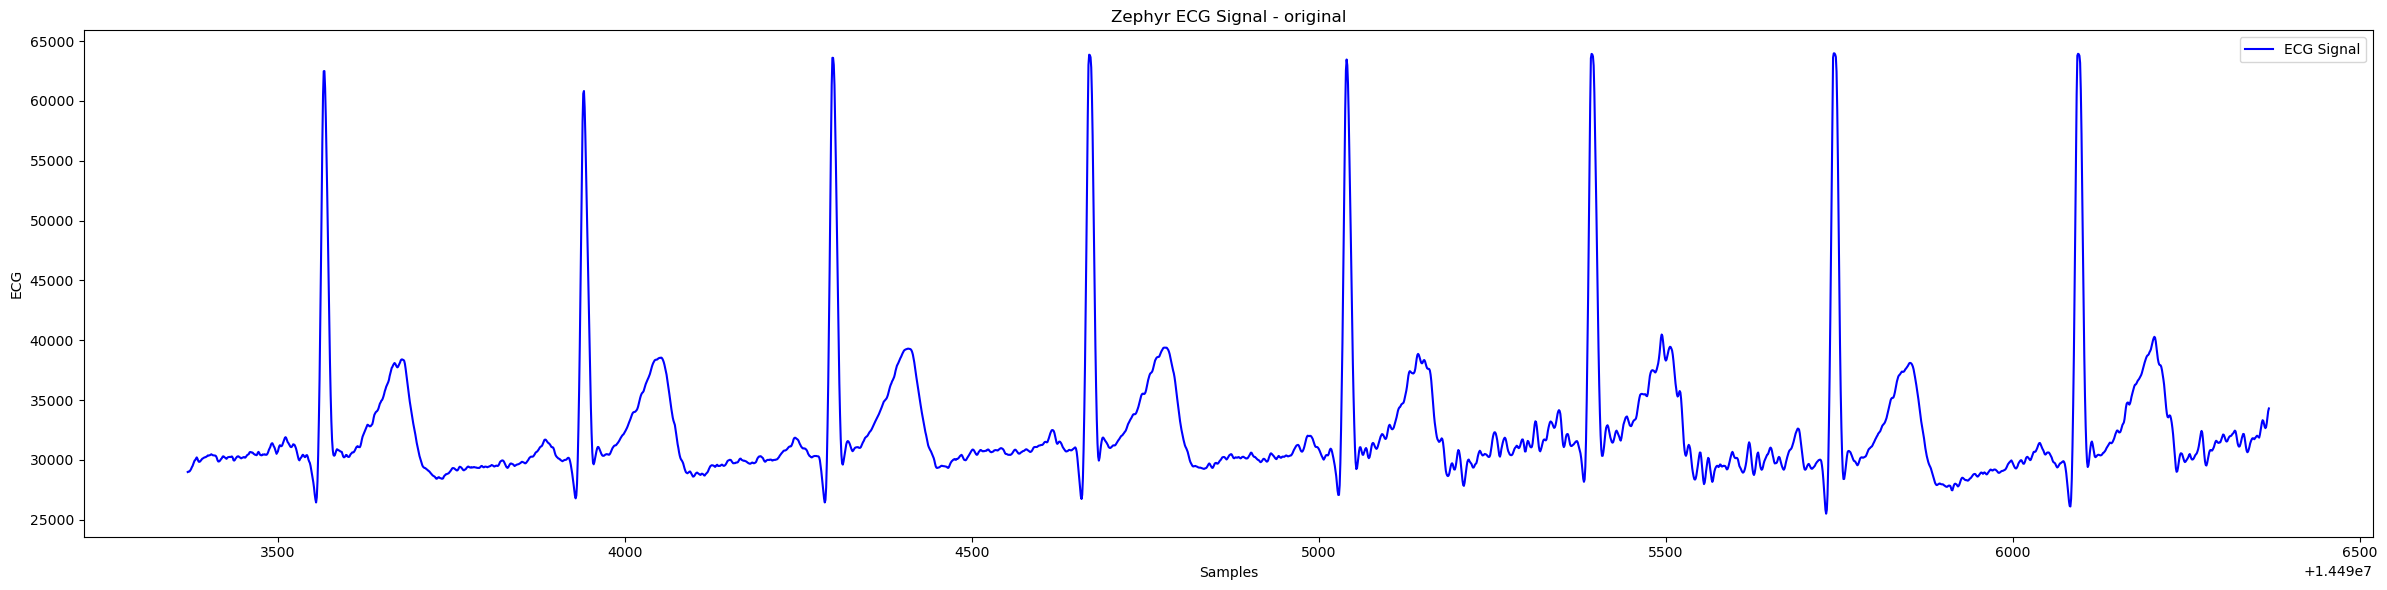

In [12]:
# Plot the ECG signal
plt.figure(figsize=(24, 6))
plt.plot(df_original['ecg'][sequence_start:sequence_stop], color='b', label="ECG Signal",)
plt.title("Zephyr ECG Signal - original")
plt.xlabel("Samples")
plt.ylabel("ECG")
plt.legend()
plt.tight_layout()

plt.savefig('../results/ecg_ppg/ecg_original.png')
plt.show()

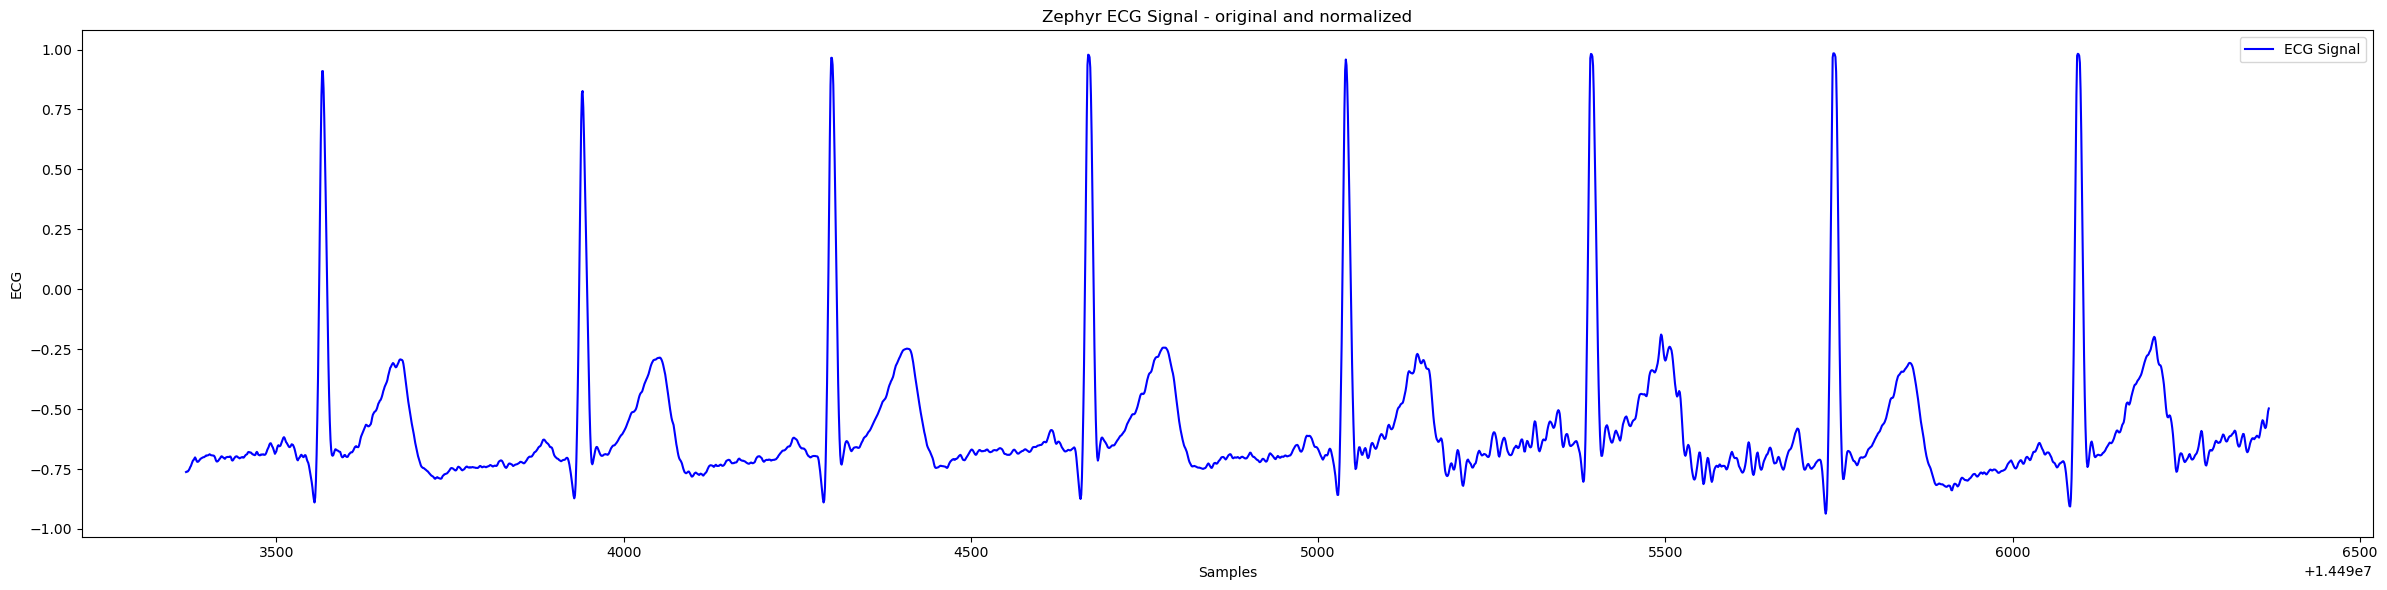

In [13]:
# Plot the ECG signal
plt.figure(figsize=(24, 6))
plt.plot(df_original_normalized['ecg'][sequence_start:sequence_stop], color='b', label="ECG Signal",)
plt.title("Zephyr ECG Signal - original and normalized")
plt.xlabel("Samples")
plt.ylabel("ECG")
plt.legend()
plt.tight_layout()

plt.savefig('../results/ecg_ppg/ecg_original_normalized.png')
plt.show()

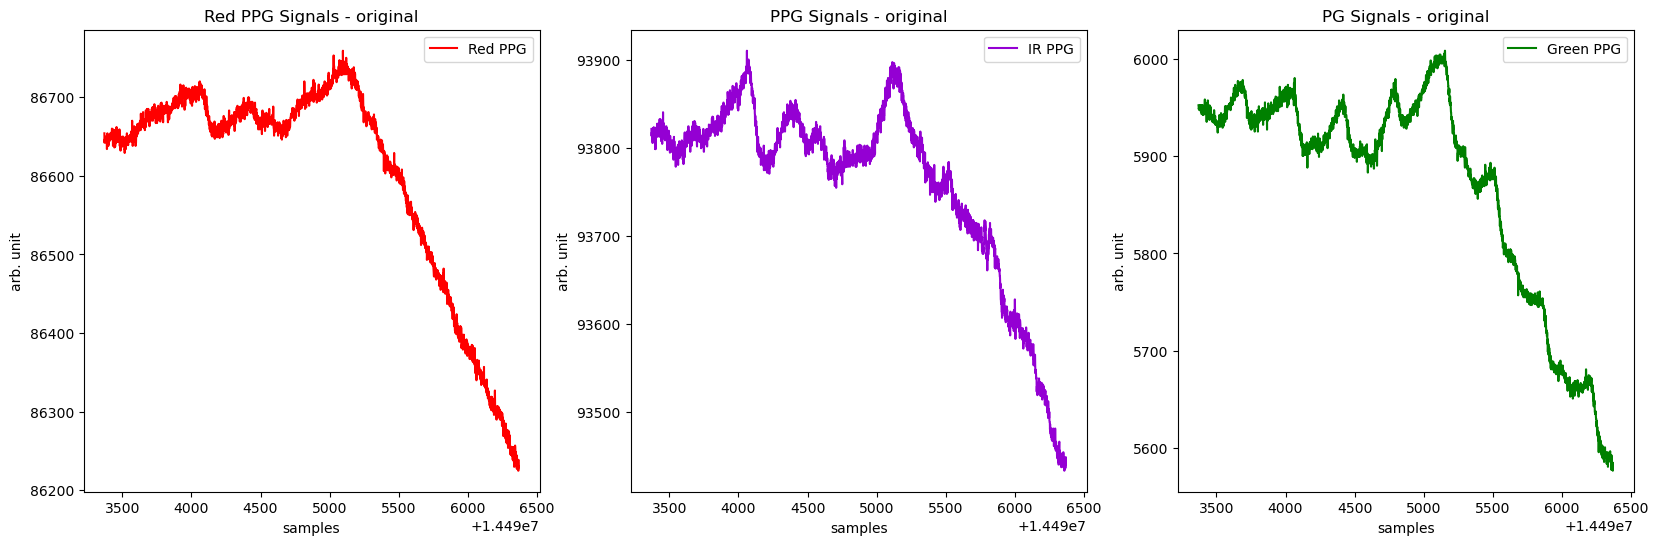

In [14]:
# Create a subplot figure showing the 3 different ppg signals
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

axes[0].plot(df_original['red ppg'][sequence_start:sequence_stop], label='Red PPG', color='r')
axes[0].set_title("Red PPG Signals - original")
axes[0].set_xlabel("samples")
axes[0].set_ylabel("arb. unit")
axes[0].legend()

axes[1].plot(df_original['ir ppg'][sequence_start:sequence_stop], label='IR PPG', color='darkviolet')
axes[1].set_title("PPG Signals - original")
axes[1].set_xlabel("samples")
axes[1].set_ylabel("arb. unit")
axes[1].legend()

axes[2].plot(df_original['green ppg'][sequence_start:sequence_stop], label='Green PPG', color='g')
axes[2].set_title("PG Signals - original")
axes[2].set_xlabel("samples")
axes[2].set_ylabel("arb. unit")
axes[2].legend()

plt.savefig('../results/ecg_ppg/ppg_original.png')
plt.show()

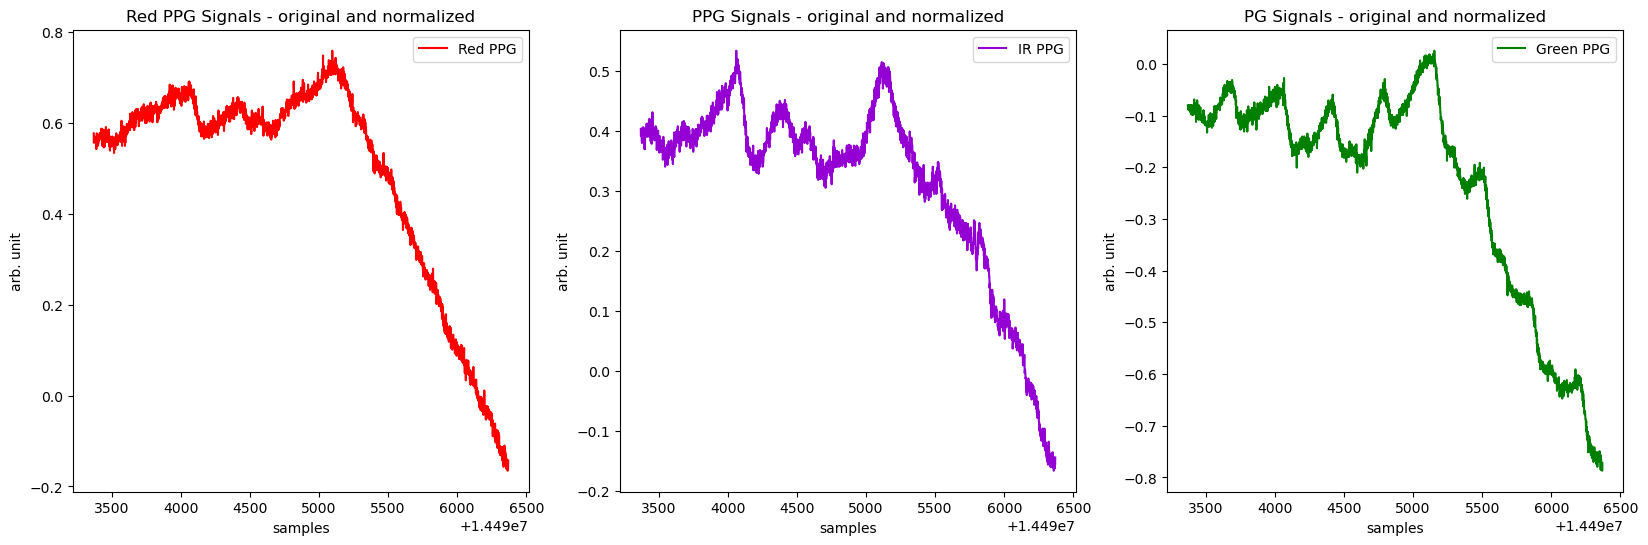

In [15]:
# Create a subplot figure showing the 3 different ppg signals
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

axes[0].plot(df_original_normalized['red ppg'][sequence_start:sequence_stop], label='Red PPG', color='r')
axes[0].set_title("Red PPG Signals - original and normalized")
axes[0].set_xlabel("samples")
axes[0].set_ylabel("arb. unit")
axes[0].legend()

axes[1].plot(df_original_normalized['ir ppg'][sequence_start:sequence_stop], label='IR PPG', color='darkviolet')
axes[1].set_title("PPG Signals - original and normalized")
axes[1].set_xlabel("samples")
axes[1].set_ylabel("arb. unit")
axes[1].legend()

axes[2].plot(df_original_normalized['green ppg'][sequence_start:sequence_stop], label='Green PPG', color='g')
axes[2].set_title("PG Signals - original and normalized")
axes[2].set_xlabel("samples")
axes[2].set_ylabel("arb. unit")
axes[2].legend()

plt.savefig('../results/ecg_ppg/ppg_original_normalized.png')
plt.show()

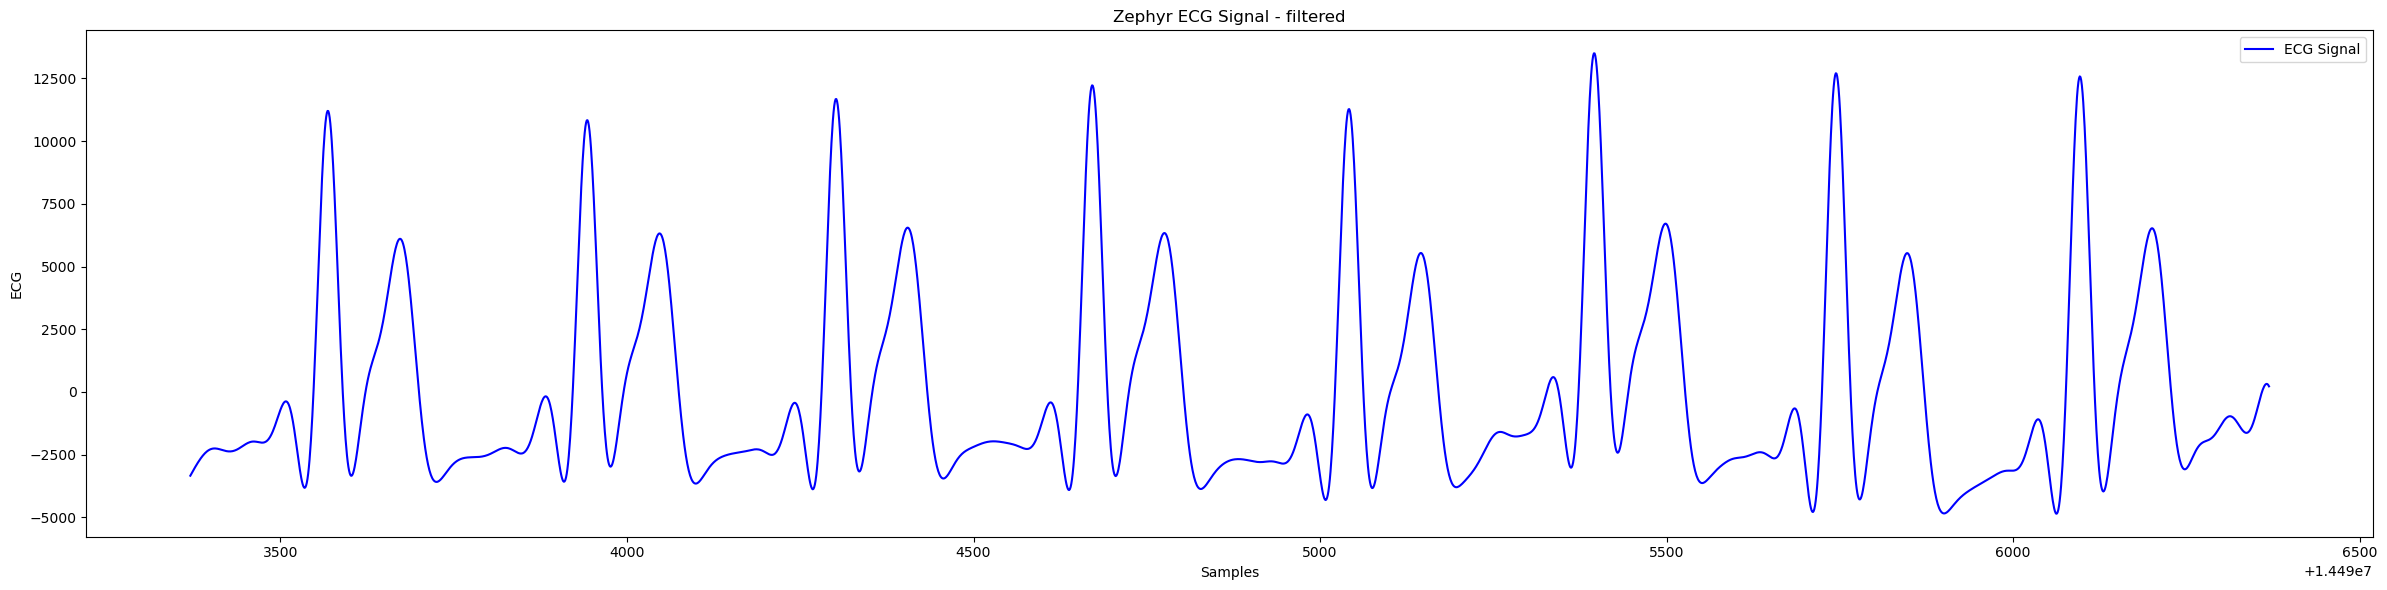

In [16]:
# Plot the ECG signal
plt.figure(figsize=(24, 6))
plt.plot(df_filtered['ecg'][sequence_start:sequence_stop], color='b', label="ECG Signal",)
plt.title("Zephyr ECG Signal - filtered")
plt.xlabel("Samples")
plt.ylabel("ECG")
plt.legend()
plt.tight_layout()

plt.savefig('../results/ecg_ppg/ecg_filtered.png')
plt.show()

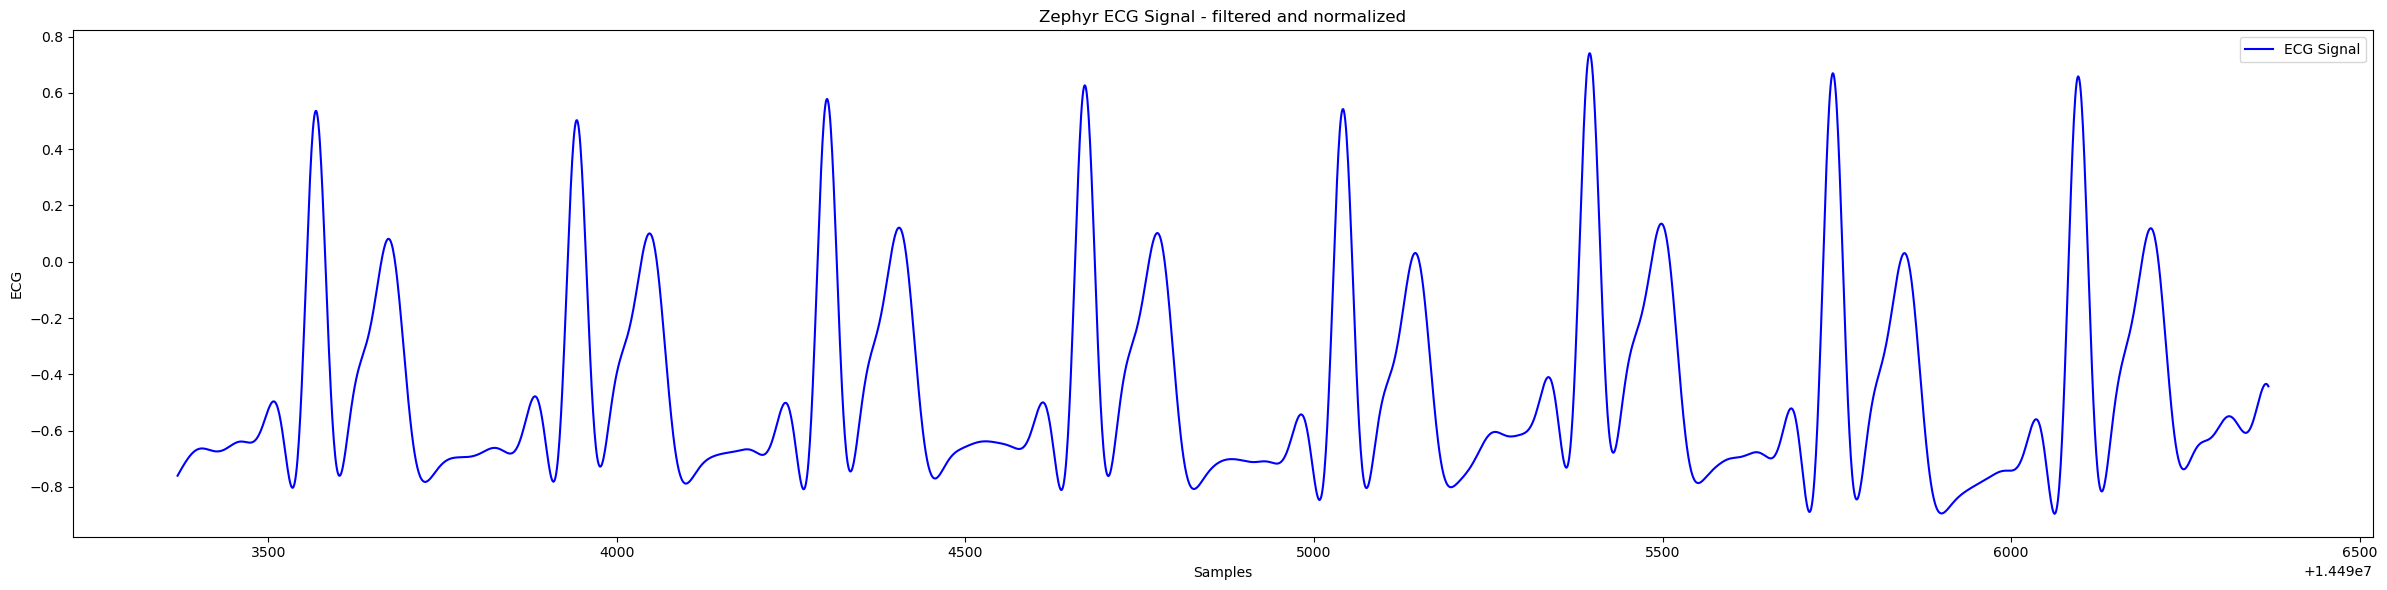

In [17]:
# Plot the ECG signal
plt.figure(figsize=(24, 6))
plt.plot(df_filtered_normalized['ecg'][sequence_start:sequence_stop], color='b', label="ECG Signal",)
plt.title("Zephyr ECG Signal - filtered and normalized")
plt.xlabel("Samples")
plt.ylabel("ECG")
plt.legend()
plt.tight_layout()

plt.savefig('../results/ecg_ppg/ecg_filtered_normalized.png')
plt.show()

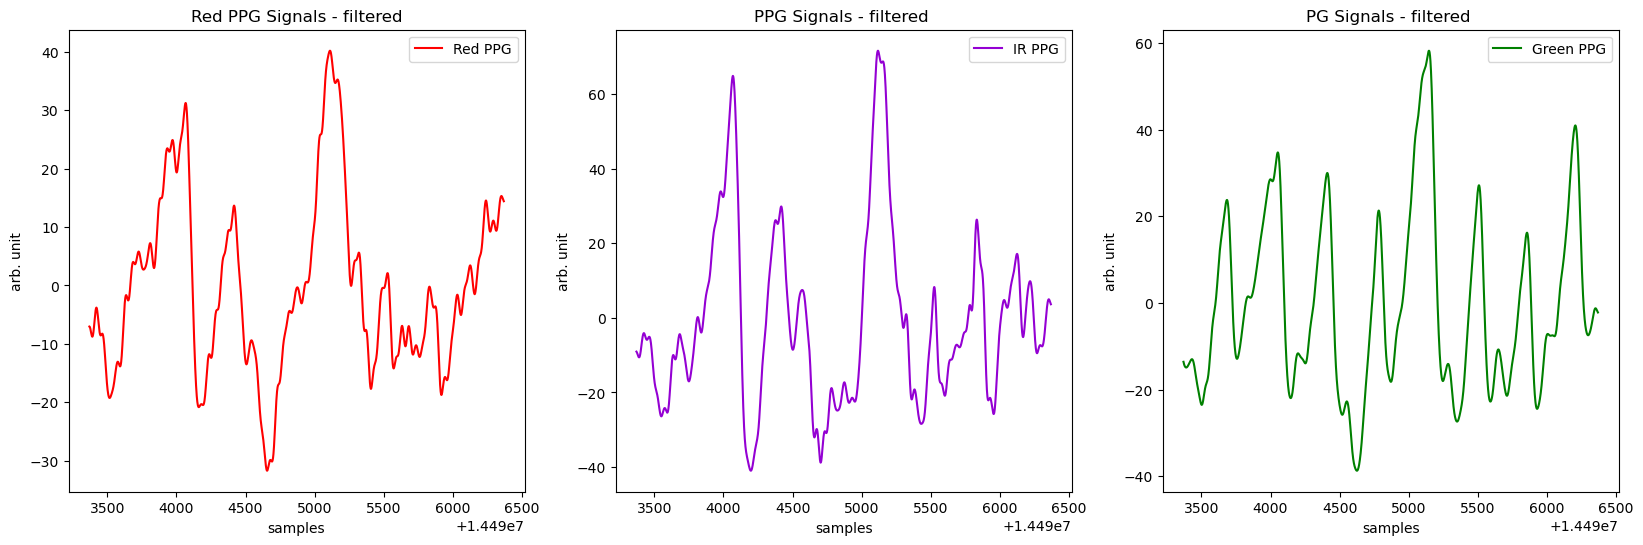

In [18]:
# Create a subplot figure showing the 3 different ppg signals
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

axes[0].plot(df_filtered['red ppg'][sequence_start:sequence_stop], label='Red PPG', color='r')
axes[0].set_title("Red PPG Signals - filtered")
axes[0].set_xlabel("samples")
axes[0].set_ylabel("arb. unit")
axes[0].legend()

axes[1].plot(df_filtered['ir ppg'][sequence_start:sequence_stop], label='IR PPG', color='darkviolet')
axes[1].set_title("PPG Signals - filtered ")
axes[1].set_xlabel("samples")
axes[1].set_ylabel("arb. unit")
axes[1].legend()

axes[2].plot(df_filtered['green ppg'][sequence_start:sequence_stop], label='Green PPG', color='g')
axes[2].set_title("PG Signals - filtered ")
axes[2].set_xlabel("samples")
axes[2].set_ylabel("arb. unit")
axes[2].legend()

plt.savefig('../results/ecg_ppg/ppg_filtered.png')
plt.show()

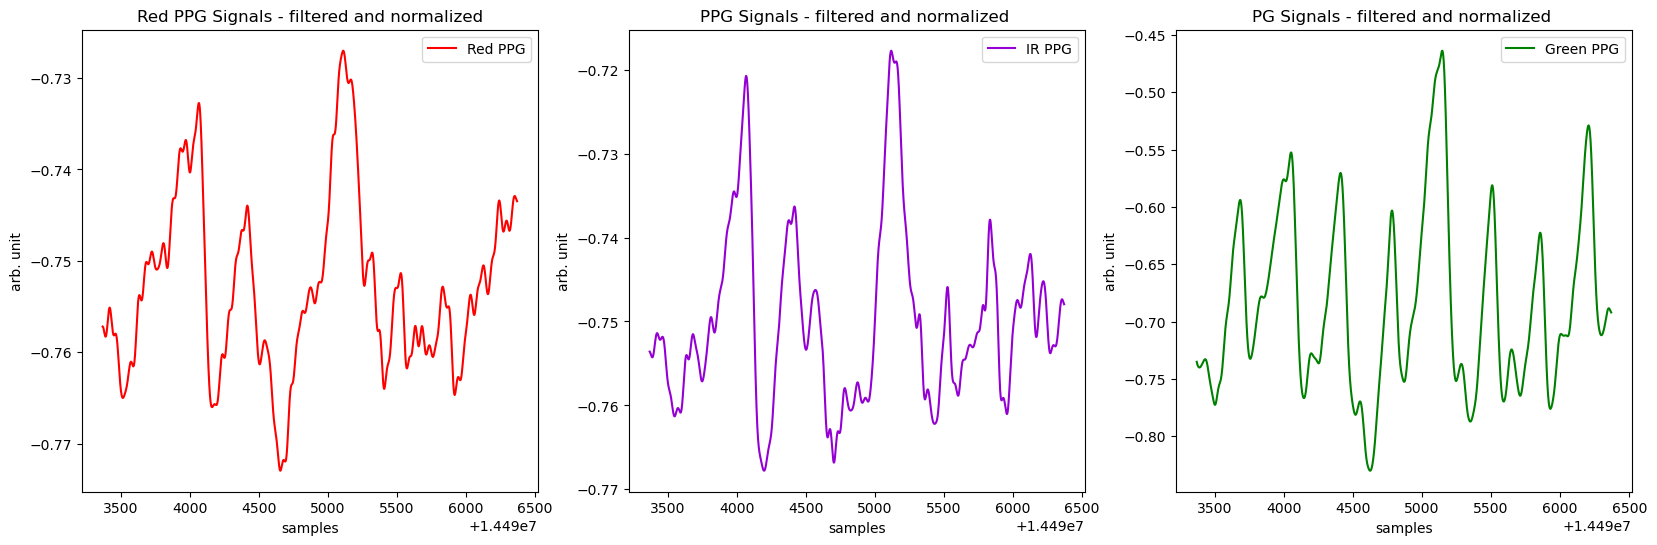

In [19]:
# Create a subplot figure showing the 3 different ppg signals
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

axes[0].plot(df_filtered_normalized['red ppg'][sequence_start:sequence_stop], label='Red PPG', color='r')
axes[0].set_title("Red PPG Signals - filtered and normalized")
axes[0].set_xlabel("samples")
axes[0].set_ylabel("arb. unit")
axes[0].legend()

axes[1].plot(df_filtered_normalized['ir ppg'][sequence_start:sequence_stop], label='IR PPG', color='darkviolet')
axes[1].set_title("PPG Signals - filtered and normalized ")
axes[1].set_xlabel("samples")
axes[1].set_ylabel("arb. unit")
axes[1].legend()

axes[2].plot(df_filtered_normalized['green ppg'][sequence_start:sequence_stop], label='Green PPG', color='g')
axes[2].set_title("PG Signals - filtered and normalized ")
axes[2].set_xlabel("samples")
axes[2].set_ylabel("arb. unit")
axes[2].legend()

plt.savefig('../results/ecg_ppg/ppg_filtered_normalized.png')
plt.show()

In [20]:
df_filtered_normalized

ecg   red ppg    ir ppg  green ppg action  subject
0        -0.164368 -0.735236 -0.739668  -0.745664    run        1
1        -0.158655 -0.734529 -0.738882  -0.746721    run        1
2        -0.152808 -0.733826 -0.738097  -0.747785    run        1
3        -0.146828 -0.733132 -0.737317  -0.748848    run        1
4        -0.140714 -0.732452 -0.736544  -0.749902    run        1
...            ...       ...       ...        ...    ...      ...
16217127  0.621431  0.735613  0.697284   0.705999   walk       22
16217128  0.563686  0.736206  0.698010   0.706974   walk       22
16217129  0.504797  0.736785  0.698713   0.707919   walk       22
16217130  0.445473  0.737347  0.699388   0.708826   walk       22
16217131  0.386404  0.737888  0.700031   0.709691   walk       22

[16217132 rows x 6 columns]

In [21]:
def sort_by_action(df, action):
    '''
    Sort the input dataframe by the desired action and return the new dataframe containing all action specific data
    '''
    # Return rows where the action matches
    return df[df['action'] == action]

In [22]:
df_action = sort_by_action(df_filtered, 'run')
df_run_normalized, scal = normalization_group_action(df_action)
df_run_normalized


                         ecg     red ppg      ir ppg   green ppg
subject action                                                  
1       run       174.974839   15.310121   36.949744    2.448764
2       run     -4260.135210   62.017004  212.866797  -69.501723
3       run      2634.365464  267.597661  394.774234   47.897000
4       run     -3479.486553   62.273653   94.969758   -2.777612
5       run     -3828.804264   77.942781   79.207784   31.739113
6       run      3477.577537   57.702821  206.730649   30.123429
7       run     -1785.308384 -409.532642    3.051427  -14.180527
8       run     -3621.562238  639.078460  172.663984   22.488465
9       run     -2188.350262 -181.440739  273.019439    8.849892
10      run     -5765.147434  529.476845  252.464629   43.997993
11      run     -1381.916146   58.807542  120.897983   -0.990909
12      run     -4740.528699  109.116455  244.418309   48.439617
13      run     -3307.436234  252.922672  292.833998   61.011354
14      run     -1226.083

ecg   red ppg    ir ppg  green ppg action  subject
0       -0.164368 -0.735236 -0.739668  -0.745664    run        1
1       -0.158655 -0.734529 -0.738882  -0.746721    run        1
2       -0.152808 -0.733826 -0.738097  -0.747785    run        1
3       -0.146828 -0.733132 -0.737317  -0.748848    run        1
4       -0.140714 -0.732452 -0.736544  -0.749902    run        1
...           ...       ...       ...        ...    ...      ...
5417428  0.201758  0.692494  0.337411  -0.102254    run       22
5417429  0.205395  0.693703  0.361691  -0.120615    run       22
5417430  0.208886  0.694991  0.386686  -0.139122    run       22
5417431  0.212196  0.696345  0.412225  -0.157682    run       22
5417432  0.215286  0.697752  0.438132  -0.176202    run       22

[5417433 rows x 6 columns]

In [23]:
df_run_normalized

ecg   red ppg    ir ppg  green ppg action  subject
0       -0.164368 -0.735236 -0.739668  -0.745664    run        1
1       -0.158655 -0.734529 -0.738882  -0.746721    run        1
2       -0.152808 -0.733826 -0.738097  -0.747785    run        1
3       -0.146828 -0.733132 -0.737317  -0.748848    run        1
4       -0.140714 -0.732452 -0.736544  -0.749902    run        1
...           ...       ...       ...        ...    ...      ...
5417428  0.201758  0.692494  0.337411  -0.102254    run       22
5417429  0.205395  0.693703  0.361691  -0.120615    run       22
5417430  0.208886  0.694991  0.386686  -0.139122    run       22
5417431  0.212196  0.696345  0.412225  -0.157682    run       22
5417432  0.215286  0.697752  0.438132  -0.176202    run       22

[5417433 rows x 6 columns]

In [24]:
## Withhold subjects for validation
num_val_subjects = 1
val_subjects = [random.randint(1,22)]
train_subjects = [random.randint(1,22)]
while (train_subjects == val_subjects):
    train_subjects = [random.randint(1,22)]
print(val_subjects, train_subjects)

val_rows = df_run_normalized[df_run_normalized['subject'].isin(val_subjects)]
train_rows = df_run_normalized[df_run_normalized['subject'].isin(train_subjects)]

# Create and append to df_val and df_train
df_val = pd.DataFrame()  # Initialize empty DataFrame
df_train = pd.DataFrame()
df_val = pd.concat([df_val, val_rows], ignore_index=True)
df_train = pd.concat([df_train, train_rows], ignore_index=True)

print(df_val)
print(df_train)

[16] [18]
             ecg   red ppg    ir ppg  green ppg action  subject
0      -0.278305  0.696226  0.678424   0.274075    run       16
1      -0.300937  0.566162  0.549638   0.174722    run       16
2      -0.323596  0.437397  0.422151   0.076518    run       16
3      -0.346150  0.310772  0.296794  -0.019900    run       16
4      -0.368468  0.187095  0.174369  -0.113924    run       16
...          ...       ...       ...        ...    ...      ...
246994  0.061077  0.782544  0.670458   0.415614    run       16
246995  0.064909  0.777940  0.687185   0.411148    run       16
246996  0.067150  0.773232  0.704364   0.406445    run       16
246997  0.067805  0.768450  0.721887   0.401542    run       16
246998  0.066902  0.763625  0.739636   0.396478    run       16

[246999 rows x 6 columns]
             ecg   red ppg    ir ppg  green ppg action  subject
0      -0.157458 -0.493537 -0.637050   0.116224    run       18
1      -0.157603 -0.379237 -0.512490   0.179005    run       18
2  

In [25]:
# ## Withhold subjects for validation
# num_val_subjects = 4
# val_subjects = []

# while len(val_subjects) < num_val_subjects: 
#     ran_sub = random.randint(1,22)
#     if ran_sub not in val_subjects:
#         val_subjects.append(ran_sub)

# val_subjects = np.sort(val_subjects)
# train_subjects = [i for i in range(1, 23) if i not in val_subjects]
# print(val_subjects, train_subjects)

# val_rows = df_filtered_normalized[df_filtered_normalized['subject'].isin(val_subjects)]
# train_rows = df_filtered_normalized[df_filtered_normalized['subject'].isin(train_subjects)]

# # Create and append to df_val and df_train
# df_val = pd.DataFrame()  # Initialize empty DataFrame
# df_train = pd.DataFrame()
# df_val = pd.concat([df_val, val_rows], ignore_index=True)
# df_train = pd.concat([df_train, train_rows], ignore_index=True)

# print(df_val)
# print(df_train)

In [26]:
df_train

ecg   red ppg    ir ppg  green ppg action  subject
0      -0.157458 -0.493537 -0.637050   0.116224    run       18
1      -0.157603 -0.379237 -0.512490   0.179005    run       18
2      -0.157665 -0.266057 -0.389123   0.241292    run       18
3      -0.157650 -0.154737 -0.267753   0.302691    run       18
4      -0.157564 -0.045990 -0.149154   0.362821    run       18
...          ...       ...       ...        ...    ...      ...
242121 -0.036090 -0.709306 -0.783739  -0.443543    run       18
242122 -0.038033 -0.679461 -0.771299  -0.399176    run       18
242123 -0.039985 -0.648935 -0.758675  -0.353849    run       18
242124 -0.041937 -0.617925 -0.745951  -0.307864    run       18
242125 -0.043880 -0.586633 -0.733211  -0.261533    run       18

[242126 rows x 6 columns]

In [27]:
def sequences(df):
    # Retrieve input ppg signals
    input_columns = ['red ppg', 'ir ppg', 'green ppg']
    x_normalized = df[input_columns].values

    # Retrieve target ecg signals
    y_normalized = df[['ecg']].values

    # Convert to PyTorch tensors
    x_data = torch.tensor(x_normalized, dtype=torch.float32)  # Shape: [samples, 3]
    y_data = torch.tensor(y_normalized, dtype=torch.float32)  # Shape: [samples, 1]

    # Reshape for sequence length and adjustable stepsize. Sequences are shifted by timestamp / sample stepsize per sequence! 
    sequence_length = 1000 
    sequence_step_size = 50
    num_sequences = len(df) - sequence_length + 1
    subset = 0.001

    x_sequences = torch.stack([x_data[i:i + sequence_length] for i in range(0, int(num_sequences*subset), int(sequence_step_size))])  # [num_sequences, seq_length, 3]
    y_sequences = torch.stack([y_data[i:i + sequence_length] for i in range(0, int(num_sequences*subset), int(sequence_step_size))])  # [num_sequences, seq_length, 1]
    return x_sequences, y_sequences

In [28]:
df_train.shape

(242126, 6)

In [29]:
X_train, y_train = sequences(df_train)
X_val, y_val = sequences(df_val)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: torch.Size([5, 1000, 3]), y_train shape: torch.Size([5, 1000, 1])
X_val shape: torch.Size([5, 1000, 3]), y_val shape: torch.Size([5, 1000, 1])


In [30]:
X_train

tensor([[[-0.4935, -0.6371,  0.1162],
         [-0.3792, -0.5125,  0.1790],
         [-0.2661, -0.3891,  0.2413],
         ...,
         [-0.5648, -0.7081,  0.0083],
         [-0.5662, -0.7137, -0.0086],
         [-0.5676, -0.7192, -0.0252]],

        [[ 0.6133,  0.5974,  0.8039],
         [ 0.6093,  0.5933,  0.8010],
         [ 0.6063,  0.5901,  0.7985],
         ...,
         [-0.5815, -0.8237, -0.3933],
         [-0.5807, -0.8222, -0.3913],
         [-0.5798, -0.8206, -0.3888]],

        [[ 0.4539,  0.4279,  0.7055],
         [ 0.4494,  0.4236,  0.7051],
         [ 0.4450,  0.4196,  0.7048],
         ...,
         [-0.5333, -0.7037, -0.1145],
         [-0.5323, -0.7013, -0.1099],
         [-0.5313, -0.6990, -0.1054]],

        [[ 0.2596,  0.2462,  0.7246],
         [ 0.2557,  0.2427,  0.7251],
         [ 0.2518,  0.2392,  0.7255],
         ...,
         [-0.4971, -0.6329,  0.0059],
         [-0.4963, -0.6309,  0.0092],
         [-0.4955, -0.6288,  0.0125]],

        [[ 0.0733,  0.07

In [31]:
# Calculate all the inverses at different processing steps for the ppg signals
x_normalized_inverse = scaler_input.inverse_transform(x_normalized)
x_data_inversed = scaler_input.inverse_transform(x_data.numpy())

ppg_real = []
for seq in x_sequences:
    seq_arry = seq.numpy()
    for i in range(0, sequence_step_size):
        ppg_real.append(seq_arry[i])

ppg_arr = np.array(ppg_real)
x_sequences_inversed = scaler_input.inverse_transform(ppg_arr)

ppg_real = []
for seq in X_val:
    seq_arry = seq.numpy()
    for i in range(0, sequence_step_size):
        ppg_real.append(seq_arry[i])

ppg_arr = np.array(ppg_real)

X_val_inversed = scaler_input.inverse_transform(ppg_arr)

NameError: name 'scaler_input' is not defined

In [ ]:
X_val_inversed

In [ ]:
x_sequences_inversed

In [ ]:
# Calculate all the inverses at different processing steps for the ecg signals
y_normalized_inversed = scaler_target.inverse_transform(y_normalized)
y_data_inversed = scaler_target.inverse_transform(y_data.numpy())

ecg_real = []
for seq in y_sequences:
    seq_arry = seq.numpy()
    for i in range(0, sequence_step_size):
        ecg_real.append(seq_arry[i])
ecg_arr = np.array(ecg_real)
y_sequences_inversed = scaler_target.inverse_transform(ecg_arr.reshape(-1, 1))

ecg_real = []
for seq in y_val:
    seq_arry = seq.numpy()
    for i in range(0, sequence_step_size):
        ecg_real.append(seq_arry[i])
ecg_arr = np.array(ecg_real)
y_val_inversed = scaler_target.inverse_transform(ecg_arr.reshape(-1, 1))

In [32]:
y_val_inversed

NameError: name 'y_val_inversed' is not defined

In [33]:
# Model initialization 
d_model = 8  # Embedding dimension
input_dim = 3  # 3 PPG signals (red, green, IR)
output_dim = 1  # 1 ECG target per time step
nhead = 2  # Attention heads
num_layers = 2  # Number of transformer layers
batch_size = 16  # Batch size


model = TransformerTimeSeries(input_dim=input_dim, output_dim=output_dim, d_model=d_model, nhead=nhead, num_layers=num_layers) 

# Loss function: Mean Squared Error for regression tasks
loss_fn = nn.MSELoss()

# Optimizer: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3  # Number of epochs to train
training_loss = np.array([])
validation_loss = np.array([])
epochs = np.array([])

### Training
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0 # Initialize running loss

    # Iterate through the training data in batches
    for i in range(0, len(X_train), batch_size):
        # Get the current batch
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)
        
        # Create the target input (tgt) for the decoder using teacher forcing
        # Shift the target sequence by one time step and add a start token
        tgt_input = torch.cat(
            [torch.zeros((batch_y.size(0), 1, batch_y.size(-1)), device=device),  # Start token (all zeros)
            batch_y[:, :-1, :]],  # Shifted target sequence
            dim=1
        )
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        predictions = model(batch_X, tgt_input) # src = batch_X, tgt = tgt_input
        print(predictions)

        # Calculate loss (MSE between predicted ECG and actual ECG)
        loss = loss_fn(predictions, batch_y)

        # Backward pass (compute gradients)
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * batch_X.size(0)

    # Calculate the average loss for the epoch
    avg_train_loss = running_loss / len(X_train)
    train_rmse = torch.sqrt(torch.tensor(avg_train_loss)) # MSE needs to be calculated at the end of each batch, scaled by batch size and the RMSE should calculated at the end of the epoch (metric)
    training_loss = np.append(training_loss, train_rmse.cpu())

    # Validation metrics with batching
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():
        for j in range(0, len(X_val), batch_size):
            # Get the current validation batch
            batch_X_val = X_val[j:j + batch_size].to(device)
            batch_y_val = y_val[j:j + batch_size].to(device)

            # Teacher forcing during validation
            tgt_input_val = torch.cat(
                [torch.zeros((batch_y_val.size(0), 1, batch_y_val.size(-1)), device=device),
                batch_y_val[:, :-1, :]],
                dim=1
            )

            # Alternative: Autoregressive decoding for inference-like validation
            # Start with an all-zero start token
            # tgt_input_val = torch.zeros((batch_y_val.size(0), 1, batch_y_val.size(-1)), device=device)
            # predictions = []
            # for _ in range(batch_y_val.size(1)):
            #     step_output = model(batch_X_val, tgt_input_val)[:, -1:, :]
            #     predictions.append(step_output)
            #     tgt_input_val = torch.cat([tgt_input_val, step_output], dim=1)
            # predictions = torch.cat(predictions, dim=1)

            # Forward pass
            val_predictions = model(batch_X_val, tgt_input_val)
            print(val_predictions)

            # Calculate loss for this batch
            val_loss = loss_fn(val_predictions, batch_y_val)

            # Accumulate total validation loss
            total_val_loss += val_loss.item() * batch_X_val.size(0)  # Weighted by batch size, necessary and if so why not for X_batch?

    # Average validation loss over all samples
    avg_val_loss = total_val_loss / len(X_val) 
    val_rmse = torch.sqrt(torch.tensor(avg_val_loss)) # MSE needs to be calculated at the end of each batch, scaled by batch size and the RMSE should calculated at the end of the epoch (metric)
    validation_loss = np.append(validation_loss, val_rmse.cpu())

    # Step the learning rate scheduler with the validation loss
    # scheduler.step(avg_val_loss)

    # # Early stopping
    # if avg_val_loss < best_val_loss - min_delta:
    #     best_val_loss = avg_val_loss
    #     early_stop_counter = 0
    #     # Save checkpoint
    #     checkpoint_path = f"{checkpoints_folder}/model_checkpoint_epoch{epoch+1}.pth"
    #     save_checkpoint(model, optimizer, epoch + 1, avg_val_loss, checkpoint_path)
    #     epochs = np.append(epochs, int(epoch+1))
    #     print(f"Checkpoint saved at epoch {epoch + 1}.")
    # else:
    #     epochs = np.append(epochs, int(epoch+1))
    #     early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print(f"Early stopping triggered after {epoch + 1} epochs.")
    #     break

    #print(f"Memory usage: {psutil.virtual_memory().percent}%")
    print(f"Epoch {epoch + 1}/{num_epochs} | Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Clear any residual memory before start of new epoch
    torch.cuda.empty_cache()

# Save the model
# torch.save(model.state_dict(), f"../models/{model_name}_s{config['parameters']['subject']}_{config['parameters']['action']}.pth")

/Users/andrifurrer/anaconda3/envs/transformer/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[[-0.2673],
         [-0.2959],
         [-0.3498],
         ...,
         [-0.7480],
         [-0.7028],
         [-0.5792]],

        [[-0.4231],
         [-0.2842],
         [-0.0822],
         ...,
         [-0.8334],
         [-0.6110],
         [-0.6331]],

        [[-0.4053],
         [-0.4916],
         [-0.2785],
         ...,
         [-0.7411],
         [-0.6938],
         [-0.7686]],

        [[-0.4578],
         [-0.4377],
         [-0.3152],
         ...,
         [-0.5732],
         [-0.6247],
         [-0.6579]],

        [[-0.5083],
         [-0.3872],
         [-0.3594],
         ...,
         [-0.6901],
         [-0.6430],
         [-0.7404]]], grad_fn=<AddBackward0>)
tensor([[[-0.3358],
         [ 0.0329],
         [ 0.0679],
         ...,
         [-0.5772],
         [-0.5658],
         [-0.4833]],

        [[-0.3128],
         [ 0.0080],
         [ 0.0126],
         ...,
         [-0.5497],
         [-0.5408],
         [-0.4968]],

        [[-0.3006],
    

In [34]:
# # Model initialization 
# d_model = 8  # Embedding dimension
# input_dim = 3  # 3 PPG signals (red, green, IR)
# output_dim = 1  # 1 ECG target per time step
# nhead = 2  # Attention heads
# num_layers = 2  # Number of transformer layers
# batch_size = 16  # Batch size


# model = TransformerTimeSeries(input_dim=input_dim, output_dim=output_dim, d_model=d_model, nhead=nhead, num_layers=num_layers) 

# # Loss function: Mean Squared Error for regression tasks
# loss_fn = nn.MSELoss()

# # Optimizer: Adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# num_epochs = 3  # Number of epochs to train
# train_loss = np.array([])
# val_loss = np.array([])
# epochs = np.array([])

# ### Training
# # Training loop
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0 # Initialize running loss

#     # Iterate through the training data in batches
#     for i in range(0, len(X_train), batch_size):
#         # Get the current batch
#         batch_X = X_train[i:i+batch_size].to(device)
#         batch_y = y_train[i:i+batch_size].to(device)
        
#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass through the model
#         predictions = model(batch_X)

#         # Calculate loss (MSE between predicted ECG and actual ECG)
#         loss = loss_fn(predictions, batch_y)

#         # Backward pass (compute gradients)
#         loss.backward()

#         # Update the weights
#         optimizer.step()

#         # Update running loss
#         running_loss += loss.item() * batch_X.size(0)

#     # Calculate the average loss for the epoch
#     avg_train_loss = running_loss / len(X_train)
#     train_rmse = torch.sqrt(torch.tensor(avg_train_loss)) # MSE needs to be calculated at the end of each batch, scaled by batch size and the RMSE should calculated at the end of the epoch (metric)
#     train_loss = np.append(train_loss, train_rmse)

#     # Validation metrics with batching
#     model.eval()  # Set model to evaluation mode
#     total_val_loss = 0

#     with torch.no_grad():
#         for j in range(0, len(X_val), batch_size):
#             # Get the current validation batch
#             batch_X_val = X_val[j:j + batch_size].to(device)
#             batch_y_val = y_val[j:j + batch_size].to(device)

#             # Forward pass
#             val_predictions = model(batch_X_val)

#             # Calculate loss for this batch
#             val_loss = loss_fn(val_predictions, batch_y_val)

#             # Accumulate total validation loss
#             total_val_loss += val_loss.item() * batch_X_val.size(0)  # Weighted by batch size, necessary and if so why not for X_batch?

#     # Average validation loss over all samples
#     avg_val_loss = total_val_loss / len(X_val) 
#     val_rmse = torch.sqrt(torch.tensor(avg_val_loss)) # MSE needs to be calculated at the end of each batch, scaled by batch size and the RMSE should calculated at the end of the epoch (metric)
#     val_loss= np.append(val_loss, val_rmse)

#     # Clear any residual memory before start of new epoch
#     torch.cuda.empty_cache()

#     #print(f"Memory usage: {psutil.virtual_memory().percent}%")
#     epochs = np.append(epochs, int(epoch+1))
#     print(f"Epoch {epoch+1}/{num_epochs} | Train RMSE Loss: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")



In [35]:
training_loss

array([0.45254719, 0.43950391, 0.42674944])

In [36]:
validation_loss

array([0.48391187, 0.48001209, 0.4761464 ])

In [37]:
epochs

array([], dtype=float64)

In [38]:
scalers

{(1, 'run'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (1, 'sit'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (1, 'walk'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (2, 'run'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (2, 'sit'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (2, 'walk'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (3, 'run'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (3, 'sit'): {'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
  'target_scaler': MinMaxScaler(feature_range=(-1, 1))},
 (3, '

In [46]:
### Validation
# Initialize storage for aggregated predictions and actual values
ecg_predictions = []
ecg_actuals = []
ppg = []
subjects = []  # Store subject info for each batch
actions = []   # Store action info for each batch

# Iterate over the validation set in batches
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for j in range(0, len(X_val), batch_size):
        # Get the current validation batch
        batch_X_val = X_val[j:j + batch_size].to(device)
        batch_y_val = y_val[j:j + batch_size].to(device)

        # Retrieve subject and action for the batch
        batch_subjects = df_val.iloc[j:j + batch_size]['subject'].values
        batch_actions = df_val.iloc[j:j + batch_size]['action'].values

        # Create the target input (tgt) for the decoder using teacher forcing
        tgt_input_val = torch.cat(
            [torch.zeros((batch_y_val.size(0), 1, batch_y_val.size(-1)), device=device),  # Start token
            batch_y_val[:, :-1, :]],  # Shifted target sequence
            dim=1
        )

        # Generate tgt_mask 
        # Shape: [seq_len_tgt, seq_len_tgt]
        tgt_mask = generate_square_subsequent_mask(tgt_input_val.size(1)).to(device)

        # Generate src_key_padding_mask 
        # Shape: [batch_size, seq_len_src]
        src_key_padding_mask = (batch_X_val[:, :, 0] == 0).to(device) # Use only one feature (i.e. one ppg signal)

        # Generate tgt_key_padding_mask (pad tokens are 0 in the target)
        # Shape: [batch_size, seq_len_tgt]
        tgt_key_padding_mask = (tgt_input_val.squeeze(-1) == 0).to(device)

        # Debugging: print mask shapes to ensure they are correct
        # assert src_key_padding_mask.shape == [batch_size, sequence_length]
        # assert src_key_padding_mask.shape == [batch_size, sequence_length]
        # print("seq_len_src", sequence_length)
        # print("tgt_len", sequence_length)
        # print(f"src_key_padding_mask shape: {src_key_padding_mask.shape}")  # Should be [batch_size, seq_len_src]
        # print(f"tgt_key_padding_mask shape: {tgt_key_padding_mask.shape}")  # Should be [batch_size, seq_len_tgt]

        memory_mask = None

        # Forward pass to get predictions
        batch_predictions = model(
            batch_X_val, 
            tgt_input_val, 
            #tgt_mask=tgt_mask, 
            src_key_padding_mask=src_key_padding_mask, 
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # Store predictions, actuals, subjects, and actions
        ecg_predictions.append(batch_predictions.cpu())  # Move to CPU for numpy/scaler operations
        ecg_actuals.append(batch_y_val.cpu())
        ppg.append(batch_X_val.cpu())
        subjects.extend(batch_subjects)
        actions.extend(batch_actions)

# Concatenate all batches
ecg_predictions = torch.cat(ecg_predictions, dim=0)
ecg_actuals = torch.cat(ecg_actuals, dim=0)
ppg = torch.cat(ppg, dim=0)

# Initialize lists for original scale data
ecg_predictions_original_scale = []
ecg_actuals_original_scale = []
ppg_original_scale = []

# Process each sequence
for i in range(len(ecg_predictions)):
    # Get subject and action for the current sequence
    subject = subjects[i]
    action = actions[i]

    # Retrieve the correct scalers
    scaler_input = scalers[(subject, action)]['input_scaler']
    scaler_target = scalers[(subject, action)]['target_scaler']

    # Inverse transform predictions and actuals for the current sequence
    ecg_pred = ecg_predictions[i].squeeze(-1).numpy()  # Shape: [sequence_length]
    ecg_act = ecg_actuals[i].squeeze(-1).numpy()       # Shape: [sequence_length]
    ppg_seq = ppg[i].numpy()                          # Shape: [sequence_length, 3]

    ecg_predictions_original_scale.append(scaler_target.inverse_transform(ecg_pred.reshape(-1, 1)).flatten())
    ecg_actuals_original_scale.append(scaler_target.inverse_transform(ecg_act.reshape(-1, 1)).flatten())
    ppg_original_scale.append(scaler_input.inverse_transform(ppg_seq))

# Convert back to arrays
ecg_predictions_original_scale = np.array(ecg_predictions_original_scale)
ecg_actuals_original_scale = np.array(ecg_actuals_original_scale)
ppg_original_scale = np.array(ppg_original_scale)

# Separate PPG channels 
red_ppg = ppg_original_scale[:, :, 0]  # Red PPG
ir_ppg = ppg_original_scale[:, :, 1]   # IR PPG
green_ppg = ppg_original_scale[:, :, 2]  # Green PPG

In [47]:
ecg_predictions_original_scale

array([[25950.477, 36215.715, 37189.45 , ..., 19062.137, 19395.596,
        21724.219],
       [26555.223, 35483.   , 35601.145, ..., 19835.469, 20085.54 ,
        21311.18 ],
       [26871.732, 37839.977, 37875.125, ..., 28525.6  , 28907.805,
        31647.572],
       [26937.205, 27561.268, 27878.504, ..., 26598.373, 26885.24 ,
        29601.812],
       [26815.623, 25616.418, 26126.668, ..., 25771.656, 26083.738,
        28758.184]], dtype=float32)

In [41]:
### Validation
# Initialize storage for aggregated predictions and actual values
ecg_predictions = []
ecg_actuals = []
ppg = []
subjects = []  # Store subject info for each batch
actions = []   # Store action info for each batch

# Iterate over the validation set in batches
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for j in range(0, len(X_val), batch_size):
        # Get the current validation batch
        batch_X_val = X_val[j:j + batch_size].to(device)
        batch_y_val = y_val[j:j + batch_size].to(device)

        # Retrieve subject and action for the batch
        batch_subjects = df_val.iloc[j:j + batch_size]['subject'].values
        batch_actions = df_val.iloc[j:j + batch_size]['action'].values

        # Forward pass to get predictions
        batch_predictions = model(batch_X_val)

        # Store predictions, actuals, subjects, and actions
        ecg_predictions.append(batch_predictions.cpu())  # Move to CPU for numpy/scaler operations
        ecg_actuals.append(batch_y_val.cpu())
        ppg.append(batch_X_val.cpu())
        subjects.extend(batch_subjects)
        actions.extend(batch_actions)

# Concatenate all batches
ecg_predictions = torch.cat(ecg_predictions, dim=0)
ecg_actuals = torch.cat(ecg_actuals, dim=0)
ppg = torch.cat(ppg, dim=0)

# Initialize lists for original scale data
ecg_predictions_original_scale = []
ecg_actuals_original_scale = []
ppg_original_scale = []

# Process each sequence
for i in range(len(ecg_predictions)):
    # Get subject and action for the current sequence
    subject = subjects[i]
    action = actions[i]

    # Retrieve the correct scalers
    scaler_input = scalers[(subject, action)]['input_scaler']
    scaler_target = scalers[(subject, action)]['target_scaler']

    # Inverse transform predictions and actuals for the current sequence
    ecg_pred = ecg_predictions[i].squeeze(-1).numpy()  # Shape: [sequence_length]
    ecg_act = ecg_actuals[i].squeeze(-1).numpy()       # Shape: [sequence_length]
    ppg_seq = ppg[i].numpy()                          # Shape: [sequence_length, 3]

    ecg_predictions_original_scale.append(scaler_target.inverse_transform(ecg_pred.reshape(-1, 1)).flatten())
    ecg_actuals_original_scale.append(scaler_target.inverse_transform(ecg_act.reshape(-1, 1)).flatten())
    ppg_original_scale.append(scaler_input.inverse_transform(ppg_seq))

# Convert back to arrays
ecg_predictions_original_scale = np.array(ecg_predictions_original_scale)
ecg_actuals_original_scale = np.array(ecg_actuals_original_scale)
ppg_original_scale = np.array(ppg_original_scale)

# Separate PPG channels 
red_ppg = ppg_original_scale[:, :, 0]  # Red PPG
ir_ppg = ppg_original_scale[:, :, 1]   # IR PPG
green_ppg = ppg_original_scale[:, :, 2]  #


TypeError: TransformerTimeSeries.forward() missing 1 required positional argument: 'tgt'

In [49]:
len(subjects)
len(actions)

16

In [50]:
ecg_predictions_original_scale.size

5000

In [ ]:
### Validation
# Initialize storage for aggregated predictions and actual values
ecg_predictions = []
ecg_actuals = []
ppg = []

# Iterate over the validation set in batches
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for j in range(0, len(X_val), batch_size):
        # Get the current validation batch
        batch_X_val = X_val[j:j + batch_size].to(device)
        batch_y_val = y_val[j:j + batch_size].to(device)

        # Forward pass to get predictions
        batch_predictions = model(batch_X_val)

        # Store predictions and actuals
        ecg_predictions.append(batch_predictions.cpu())  # Move to CPU for numpy/scaler operations
        ecg_actuals.append(batch_y_val.cpu())
        ppg.append(batch_X_val.cpu())

# Concatenate all batches
ecg_predictions = torch.cat(ecg_predictions, dim=0)
ecg_actuals = torch.cat(ecg_actuals, dim=0)
ppg = torch.cat(ppg, dim=0)

# Reverse transform predicted ECG to original scale
ecg_predictions = ecg_predictions.squeeze(-1)
ecg_predictions_original_scale = scaler_target.inverse_transform(ecg_predictions.numpy())
print(ecg_predictions_original_scale.shape)

# Reverse transform actual ECG to original scale
ecg_actuals = ecg_actuals.squeeze(-1)
ecg_actuals_original_scale = scaler_target.inverse_transform(ecg_actuals.numpy())
print(ecg_actuals_original_scale.shape)

# Reverse transform ppg to orignial scale
print(ppg.shape)
input_ppg = ppg.squeeze(-1)
print(input_ppg.shape)
input_ppg_reshaped = input_ppg.reshape(-1, input_ppg.shape[-1])
print("Reshaped ppg:", type(input_ppg_reshaped), '/n', input_ppg_reshaped.shape)
ppg_original_scale_reshaped = scaler_input.inverse_transform(input_ppg_reshaped)
print("Inverse transformed ppg:", type(ppg_original_scale_reshaped), '/n', ppg_original_scale_reshaped.shape)
ppg_original_scale = ppg_original_scale_reshaped.reshape(input_ppg.shape)
#ppg_original_scale = scaler_input.inverse_transform(input_ppg.numpy())
print("OS Inverse transformed ppg:", type(ppg_original_scale), '/n', ppg_original_scale.shape)
print(ppg_original_scale)


# Separate PPG channels 
red_ppg = ppg_original_scale[:, :, 0]  # Red PPG
ir_ppg = ppg_original_scale[:, :, 1]   # IR PPG
green_ppg = ppg_original_scale[:, :, 2]  # Green PPG

In [51]:
ecg_actuals_original_scale

array([[26963.34 , 26332.178, 25700.23 , ..., 39837.867, 40124.78 ,
        40426.71 ],
       [27651.43 , 28178.54 , 28671.73 , ..., 50546.414, 50305.62 ,
        50024.86 ],
       [23165.316, 23810.37 , 24457.95 , ..., 21836.676, 21765.533,
        21715.23 ],
       [39847.977, 40231.64 , 40622.72 , ..., 25162.914, 25201.86 ,
        25237.498],
       [46546.266, 46048.273, 45524.3  , ..., 26539.797, 26514.611,
        26489.613]], dtype=float32)

In [52]:
X_val_inversed.shape

NameError: name 'X_val_inversed' is not defined

In [53]:
ppg_original_scale.shape

(5, 1000, 3)

In [54]:
ecg_predictions_original_scale.shape

(5, 1000)

In [ ]:
ecg_actuals_original_scale.shape

In [55]:
### Evaluation metrics
# Predictions and actual values (already scaled back to original scale)
ecg_predictions_original_scale_flattened = ecg_predictions_original_scale.flatten()  # Flatten to 1D if necessary
ecg_actuals_original_scale_flattened = ecg_actuals_original_scale.flatten()

print("Unique values in predictions:", np.unique(ecg_predictions_original_scale_flattened))
print("Unique values in actuals:", np.unique(ecg_actuals_original_scale_flattened))

# Calculate the range of the actual data for normalization
actual_range = np.ptp(ecg_actuals_original_scale)  # Peak-to-peak (max - min)

# Euclidean Distance
euclidean_distance = euclidean(ecg_predictions_original_scale_flattened, ecg_actuals_original_scale_flattened)

# Dynamic Time Warping (DTW)
downsampling_factor = 10
batch_size = 10 
dtw_distance = compute_batched_dtw(ecg_predictions_original_scale_flattened, ecg_actuals_original_scale_flattened, batch_size, downsampling_factor)
# dtw_distance = alignment.distance

# Pearson Correlation
pearson_corr, _ = pearsonr(ecg_predictions_original_scale_flattened, ecg_actuals_original_scale_flattened)

# Spearman Correlation
spearman_corr, _ = spearmanr(ecg_predictions_original_scale_flattened, ecg_actuals_original_scale_flattened)

# Mean Squared Error (MSE)
mse = np.mean((ecg_predictions_original_scale_flattened - ecg_actuals_original_scale_flattened) ** 2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(ecg_predictions_original_scale_flattened - ecg_actuals_original_scale_flattened))

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / actual_range

# Normalized Mean Absolute Error (NMAE)
nmae = mae / actual_range

# Print metrics
metrics = {
    "Euclidean Distance": euclidean_distance,
    "DTW Distance": dtw_distance,
    "Pearson Correlation": pearson_corr,
    "Spearman Correlation": spearman_corr,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "NRMSE": nrmse,
    "NMAE": nmae,
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Unique values in predictions: [13601.412  13743.2705 13755.261  ... 43383.008  43831.465  43924.234 ]
Unique values in actuals: [17297.48  17306.395 17326.63  ... 51199.22  51225.035 51225.74 ]
Euclidean Distance: 938949.9375
DTW Distance: 10484.8588
Pearson Correlation: -0.5947
Spearman Correlation: -0.6229
MSE: 176325536.0000
RMSE: 13278.7627
MAE: 10599.8828
NRMSE: 0.3914
NMAE: 0.3124


In [56]:
ppg_original_scale

array([[[79836.86  , 93405.01  ,  5943.808 ],
        [79790.555 , 93320.91  ,  5890.952 ],
        [79744.71  , 93237.664 ,  5838.708 ],
        ...,
        [79869.09  , 93477.16  ,  6149.7466],
        [79868.89  , 93477.055 ,  6150.9414],
        [79868.69  , 93476.99  ,  6152.1714]],

       [[79393.18  , 92599.47  ,  5464.219 ],
        [79394.875 , 92602.586 ,  5466.8013],
        [79396.18  , 92605.    ,  5468.9307],
        ...,
        [79857.11  , 93457.8   ,  6163.041 ],
        [79856.83  , 93456.72  ,  6160.3535],
        [79856.555 , 93455.64  ,  6157.5293]],

       [[79460.66  , 92728.91  ,  5580.9756],
        [79462.66  , 92732.81  ,  5584.5015],
        [79464.6   , 92736.63  ,  5587.979 ],
        ...,
        [79844.64  , 93417.51  ,  5980.009 ],
        [79844.45  , 93417.14  ,  5977.7285],
        [79844.27  , 93416.8   ,  5975.521 ]],

       [[79546.79  , 92892.16  ,  5743.0806],
        [79548.48  , 92894.88  ,  5746.2017],
        [79550.16  , 92897.54  ,  5

In [59]:
training_loss

array([0.45254719, 0.43950391, 0.42674944])

ValueError: x and y must have same first dimension, but have shapes (0,) and (3,)

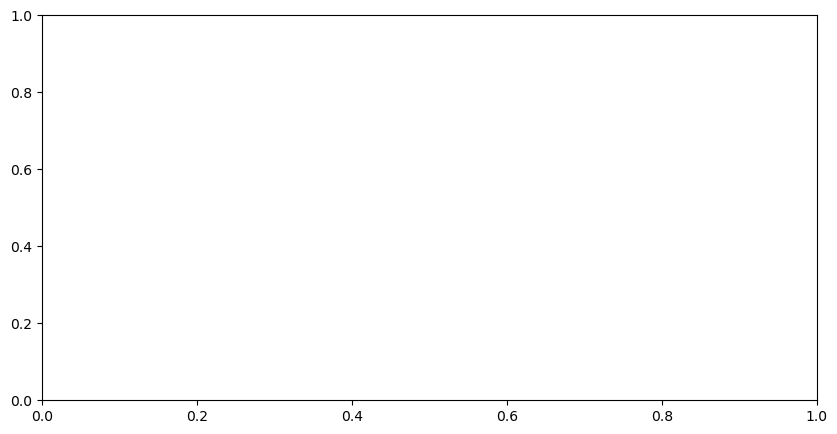

In [62]:
### Creating graphs
# Plot the training and valdiation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title(f"Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.show()

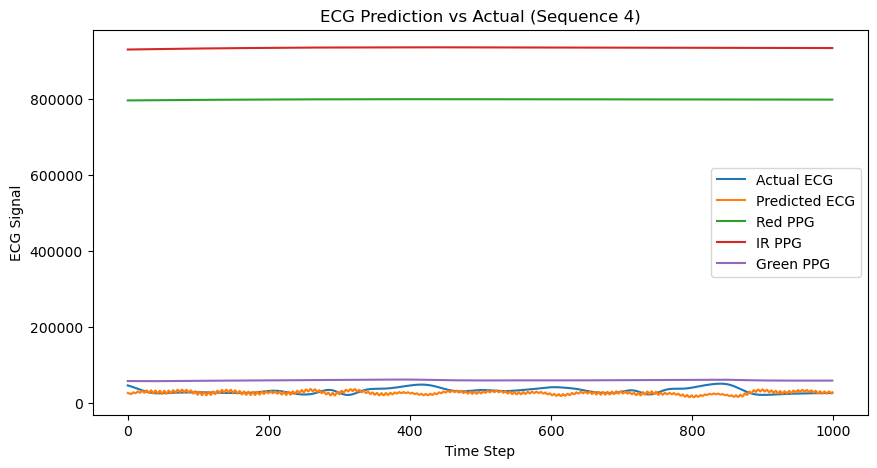

In [63]:
random_index = np.random.randint(0, len(ecg_predictions_original_scale))
ppg_scaling_factor = 10

# Select the corresponding actual and predicted ECG signals
ecg_predictions_random = ecg_predictions_original_scale[random_index]  # Predicted ECG signal
ecg_actuals_random = ecg_actuals_original_scale[random_index]  # Actual ECG signal

# Plot the actual and predicted ECG
plt.figure(figsize=(10, 5))
plt.plot(ecg_actuals_random, label='Actual ECG')
plt.plot(ecg_predictions_random, label='Predicted ECG')
plt.plot(ppg_scaling_factor*red_ppg[random_index], label="Red PPG")
plt.plot(ppg_scaling_factor*ir_ppg[random_index], label="IR PPG")
plt.plot(ppg_scaling_factor*green_ppg[random_index], label="Green PPG")
plt.title(f"ECG Prediction vs Actual (Sequence {random_index})")
plt.xlabel('Time Step')
plt.ylabel('ECG Signal')
plt.legend()

plt.show()

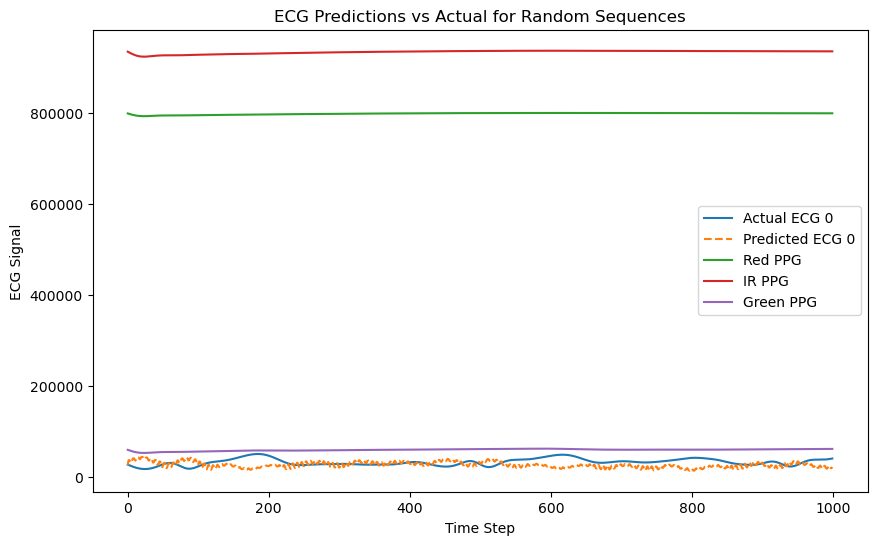

In [64]:
# Number of random sequences to plot
num_sequences = 1

# Create a plot
plt.figure(figsize=(10, 6))

for _ in range(num_sequences):
    random_index = np.random.randint(0, len(ecg_predictions_original_scale))
    
    # Select the corresponding actual and predicted ECG signals
    ecg_predictions_random = ecg_predictions_original_scale[random_index]  # Predicted ECG signal
    ecg_actuals_random = ecg_actuals_original_scale[random_index]  # Actual ECG signal

    # Plot both actual and predicted ECG
    plt.plot(ecg_actuals_random, label=f'Actual ECG {random_index}')
    plt.plot(ecg_predictions_random, label=f'Predicted ECG {random_index}', linestyle='dashed')
    plt.plot(ppg_scaling_factor*red_ppg[random_index], label="Red PPG")
    plt.plot(ppg_scaling_factor*ir_ppg[random_index], label="IR PPG")
    plt.plot(ppg_scaling_factor*green_ppg[random_index], label="Green PPG")

plt.title("ECG Predictions vs Actual for Random Sequences")
plt.xlabel('Time Step')
plt.ylabel('ECG Signal')
plt.legend()

plt.show()

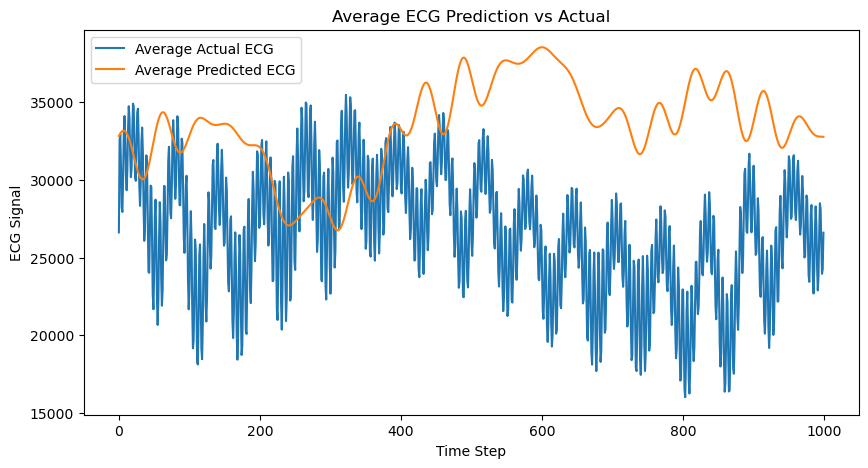

In [65]:
# Calculate the average ECG for both actual and predicted
ecg_predictions_average = np.mean(ecg_actuals_original_scale, axis=0)  # Average over all predictions
ecg_actuals_average = np.mean(ecg_predictions_original_scale, axis=0)  # Average over all sequences

# Plot the average ECG
plt.figure(figsize=(10, 5))
plt.plot(ecg_actuals_average, label='Average Actual ECG')
plt.plot(ecg_predictions_average, label='Average Predicted ECG')
plt.title("Average ECG Prediction vs Actual")
plt.xlabel('Time Step')
plt.ylabel('ECG Signal')
plt.legend()

plt.show()

In [66]:
# Reverse transform input if needed
y_val = y_val.squeeze(-1)
print(y_val.size())
inputs_original_scale = scaler_target.inverse_transform(y_val.numpy())
print(inputs_original_scale.shape)

torch.Size([5, 1000])
(5, 1000)


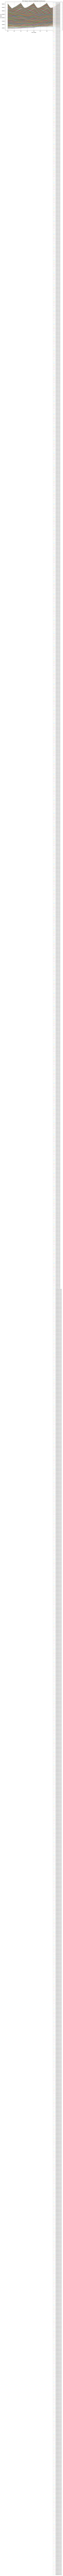

In [67]:
# Plot the continuous signal
plt.figure(figsize=(12, 6))
plt.plot(inputs_original_scale, label='Actual ECG', alpha=0.7, linestyle='-', linewidth=1.5)
plt.plot(ecg_predictions_original_scale, label='Predicted ECG', alpha=0.7, linestyle='--', linewidth=1.5)
plt.title('ECG Signal: Actual vs Predicted (Continuous)')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()